## Contents


1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
4. [Deploying the XGBoost endpoint](#Deploying-the-XGBoost-endpoint)
5. [Explaining Model Predictions](#Explain-the-model's-predictions-on-each-data-point)
6. [Delete the Inference Endpoint](#Delete-Endpoint)

## Introduction
    
This notebook shows how you can configure the SageMaker XGBoost model server by defining the following three functions in the Python source file you pass to the XGBoost constructor in the SageMaker Python SDK:
- `input_fn`: Takes request data and deserializes the data into an object for prediction,
- `predict_fn`: Takes the deserialized request object and performs inference against the loaded model, and
- `output_fn`: Takes the result of prediction and serializes this according to the response content type.
We will write a customized inference script that is designed to illustrate how [SHAP](https://github.com/slundberg/shap) values enable the interpretion of XGBoost models.

We use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).  In this libsvm converted version, the nominal feature (Male/Female/Infant) has been converted into a real valued feature as required by XGBoost. Age of abalone is to be predicted from eight physical measurements.

This notebook uses the Abalone dataset to deploy a model server that returns SHAP values, which enable us to create model explanation such as the following plots that show each features contributing to push the model output from the base value.

<table><tr>
    <td> <img src="images/output_8_0.png"/> </td>
    <td> <img src="images/output_9_0.png"/> </td>
</tr></table>

## Setup
    
This notebook was tested in Amazon SageMaker Studio on a `ml.t3.medium` instance.

Let's start by specifying:

1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
<br>
<br>
2. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regex with a the appropriate full IAM role arn string(s).

In [1]:
# !pip3 install -U sagemaker

In [2]:
%%time

import io
import os
import boto3
import sagemaker
import time

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-xgboost-inference-script-mode"

CPU times: user 971 ms, sys: 172 ms, total: 1.14 s
Wall time: 18.6 s


### Fetching the dataset

The following methods download the Abalone dataset and upload files to S3:

In [3]:
%%time
s3 = boto3.client("s3")
# Load the dataset
FILE_DATA = "abalone"
s3.download_file(
    "sagemaker-sample-files", f"datasets/tabular/uci_abalone/abalone.libsvm", FILE_DATA
)
sagemaker.Session().upload_data(FILE_DATA, bucket=bucket, key_prefix=prefix + "/train")

CPU times: user 151 ms, sys: 15.6 ms, total: 167 ms
Wall time: 976 ms


's3://sagemaker-us-west-1-167762637358/sagemaker/DEMO-xgboost-inference-script-mode/train/abalone'

## Training the XGBoost model
    
SageMaker can now run an XGboost script using the XGBoost estimator. A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. In this notebook, we use the same training script [abalone.py](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/abalone.py) from [Regression with Amazon SageMaker XGBoost algorithm](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_abalone_dist_script_mode.ipynb). Refer to [Regression with Amazon SageMaker XGBoost algorithm](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_abalone_dist_script_mode.ipynb) for details on the training script.

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between few minutes.

To run our training script on SageMaker, we construct a `sagemaker.xgboost.estimator.XGBoost` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __framework_version__: SageMaker XGBoost version you want to use for executing your model training code, e.g., `1.0-1`, `1.2-2`, `1.3-1`, or `1.5-1`.
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

In [4]:
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

job_name = "DEMO-xgboost-inference-script-mode-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Training job", job_name)

hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "reg:squarederror",
    "num_round": "50",
    "verbosity": "2",
}

instance_type = "ml.c5.xlarge"

xgb_script_mode_estimator = XGBoost(
    entry_point="abalone.py",
    hyperparameters=hyperparameters,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    framework_version="1.5-1",
    output_path="s3://{}/{}/{}/output".format(bucket, prefix, job_name),
)

content_type = "text/libsvm"
train_input = TrainingInput(
    "s3://{}/{}/{}/".format(bucket, prefix, "train"), content_type=content_type
)

Training job DEMO-xgboost-inference-script-mode-2022-08-18-20-51-25


### Train XGBoost Estimator on Abalone Data 
    
Training is as simple as calling `fit` on the Estimator. This will start a SageMaker Training job that will download the data, invoke the entry point code (in the provided script file), and save any model artifacts that the script creates. In this case, the script requires a `train` and a `validation` channel. Since we only created a `train` channel, we re-use it for validation:

In [7]:
xgb_script_mode_estimator.fit({"train": train_input, "validation": train_input}, job_name=job_name)

2022-08-18 20:53:40 Starting - Starting the training job...
2022-08-18 20:53:55 Starting - Preparing the instances for trainingProfilerReport-1660856020: InProgress
......
2022-08-18 20:55:09 Downloading - Downloading input data...
2022-08-18 20:55:38 Training - Downloading the training image.....[2022-08-18 20:56:18.701 ip-10-0-180-2.us-west-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-18:20:56:18:INFO] Imported framework sagemaker_xgboost_container.training
[2022-08-18:20:56:18:INFO] No GPUs detected (normal if no gpus installed)
[2022-08-18:20:56:18:INFO] Invoking user training script.
[2022-08-18:20:56:19:INFO] Module abalone does not provide a setup.py. 
Generating setup.py
[2022-08-18:20:56:19:INFO] Generating setup.cfg
[2022-08-18:20:56:19:INFO] Generating MANIFEST.in
[2022-08-18:20:56:19:INFO] Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Preparing metadata (setup.py): sta

After training, we can host the newly created model in SageMaker, and create an Amazon SageMaker endpoint – a hosted and managed prediction service that we can use to perform inference. If you call `deploy` after you call `fit` on an XGBoost estimator, it will create a SageMaker endpoint using the training script (i.e., `entry_point`). You can also optionally specify other functions to customize the behavior of deserialization of the input request (`input_fn()`), serialization of the predictions (`output_fn()`), and how predictions are made (`predict_fn()`). If any of these functions are not specified, the endpoint will use the default functions in the SageMaker XGBoost container. See the [SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/using_xgboost.html#sagemaker-xgboost-model-server) for details.
    
In this notebook, we will run a separate inference script and customize the endpoint to return [SHAP](https://github.com/slundberg/shap) values in addition to predictions. The inference script that we will run in this notebook is provided as the accompanying file (`inference.py` | [Link](https://github.com/flatiron-school/DS-Deloitte-07062022-Architecting-Pipelines-with-AWS/blob/main/helpers/inference.py)) and also shown below:

```
import json
import os
import pickle as pkl

import numpy as np

import sagemaker_xgboost_container.encoder as xgb_encoders


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    model_file = "xgboost-model"
    booster = pkl.load(open(os.path.join(model_dir, model_file), "rb"))
    return booster


def input_fn(request_body, request_content_type):
    """
    The SageMaker XGBoost model server receives the request data body and the content type,
    and invokes the `input_fn`.

    Return a DMatrix (an object that can be passed to predict_fn).
    """
    if request_content_type == "text/libsvm":
        return xgb_encoders.libsvm_to_dmatrix(request_body)
    else:
        raise ValueError(
            "Content type {} is not supported.".format(request_content_type)
        )


def predict_fn(input_data, model):
    """
    SageMaker XGBoost model server invokes `predict_fn` on the return value of `input_fn`.

    Return a two-dimensional NumPy array where the first columns are predictions
    and the remaining columns are the feature contributions (SHAP values) for that prediction.
    """
    prediction = model.predict(input_data)
    feature_contribs = model.predict(input_data, pred_contribs=True, validate_features=False)
    output = np.hstack((prediction[:, np.newaxis], feature_contribs))
    return output


def output_fn(predictions, content_type):
    """
    After invoking predict_fn, the model server invokes `output_fn`.
    """
    if content_type == "text/csv":
        return ','.join(str(x) for x in predictions[0])
    else:
        raise ValueError("Content type {} is not supported.".format(content_type))
```

## Deploying the XGBoost endpoint

### Deploy to an endpoint
    
Since the inference script is separate from the training script, here we use `XGBoostModel` to create a model from s3 artifacts and specify `inference.py` as the `entry_point`:

In [8]:
from sagemaker.xgboost.model import XGBoostModel

model_data = xgb_script_mode_estimator.model_data
print(model_data)

xgb_inference_model = XGBoostModel(
    model_data=model_data,
    role=role,
    entry_point="inference.py",
    framework_version="1.5-1",
)

s3://sagemaker-us-west-1-167762637358/sagemaker/DEMO-xgboost-inference-script-mode/DEMO-xgboost-inference-script-mode-2022-08-18-20-51-25/output/DEMO-xgboost-inference-script-mode-2022-08-18-20-51-25/output/model.tar.gz


In [9]:
predictor = xgb_inference_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.xlarge",
)

-----!

## Explain the model's predictions on each data point

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_feature_contributions(prediction):

    attribute_names = [
        "Sex",  # nominal / -- / M, F, and I (infant)
        "Length",  # continuous / mm / Longest shell measurement
        "Diameter",  # continuous / mm / perpendicular to length
        "Height",  # continuous / mm / with meat in shell
        "Whole weight",  # continuous / grams / whole abalone
        "Shucked weight",  # continuous / grams / weight of meat
        "Viscera weight",  # continuous / grams / gut weight (after bleeding)
        "Shell weight",  # continuous / grams / after being dried
    ]

    prediction, _, *shap_values, bias = prediction

    if len(shap_values) != len(attribute_names):
        raise ValueError("Length mismatch between shap values and attribute names.")

    df = pd.DataFrame(data=[shap_values], index=["SHAP"], columns=attribute_names).T
    df.sort_values(by="SHAP", inplace=True)

    df["bar_start"] = bias + df.SHAP.cumsum().shift().fillna(0.0)
    df["bar_end"] = df.bar_start + df.SHAP
    df[["bar_start", "bar_end"]] = np.sort(df[["bar_start", "bar_end"]].values)
    df["hue"] = df.SHAP.apply(lambda x: 0 if x > 0 else 1)

    sns.set(style="white")

    ax1 = sns.barplot(x=df.bar_end, y=df.index, data=df, orient="h", palette="vlag")
    for idx, patch in enumerate(ax1.patches):
        x_val = patch.get_x() + patch.get_width() + 0.8
        y_val = patch.get_y() + patch.get_height() / 2
        shap_value = df.SHAP.values[idx]
        value = "{0}{1:.2f}".format("+" if shap_value > 0 else "-", shap_value)
        ax1.annotate(value, (x_val, y_val), ha="right", va="center")

    ax2 = sns.barplot(x=df.bar_start, y=df.index, data=df, orient="h", color="#FFFFFF")
    ax2.set_xlim(
        df[["bar_start", "bar_end"]].values.min() - 1, df[["bar_start", "bar_end"]].values.max() + 1
    )
    ax2.axvline(x=bias, color="#000000", alpha=0.2, linestyle="--", linewidth=1)
    ax2.set_title("base value: {0:.1f}  →  model output: {1:.1f}".format(bias, prediction))
    ax2.set_xlabel("Abalone age")

    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.show()


def predict_and_plot(predictor, libsvm_str):
    label, *features = libsvm_str.strip().split()
    predictions = predictor.predict(" ".join(["-99"] + features))  # use dummy label -99
    np_array = np.array([float(x) for x in predictions[0]])
    plot_feature_contributions(np_array)

Matplotlib is building the font cache; this may take a moment.


The below figure shows features each contributing to push the model output from the base value (9.9 rings) to the model output (6.9 rings). The primary indicator for a young abalone according to the model is low shell weight, which decreases the prediction by 3.0 rings from the base value of 9.9 rings. Whole weight and shucked weight are also powerful indicators. The whole weight pushes the prediction lower by 0.84 rings, while shucked weight pushes the prediction higher by 1.6 rings:

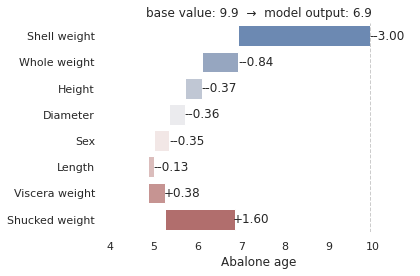

In [11]:
a_young_abalone = "6 1:3 2:0.37 3:0.29 4:0.095 5:0.249 6:0.1045 7:0.058 8:0.067"
predict_and_plot(predictor, a_young_abalone)

The second example shows feature contributions for another sample, an old abalone. We again see that the primary indicator for the age of abalone according to the model is shell weight, which increases the model prediction by 2.36 rings. Whole weight and shucked weight also contribute significantly, and they both push the model's prediction higher:

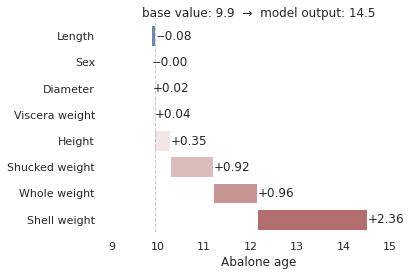

In [12]:
an_old_abalone = "15 1:1 2:0.655 3:0.53 4:0.175 5:1.2635 6:0.486 7:0.2635 8:0.415"
predict_and_plot(predictor, an_old_abalone)

## Delete Endpoint

Run the `delete_endpoint` to remove the hosted endpoint and avoid any charges from a stray instance being left on:

In [13]:
predictor.delete_endpoint()